# 1. Loading Libraries and Dataset

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import random
from PIL import Image
import glob
from pathlib import Path

# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor
import torch.optim as optim
import torchvision.models as models

# Import libraries for Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Other Libraries
from tqdm.auto import tqdm
from timeit import default_timer as timer

# Check versions
print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


In [3]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1.1 Downloading Dataset

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("salader/dogs-vs-cats")

print("Path to dataset files:", path)

100%|██████████| 1.06G/1.06G [00:26<00:00, 44.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/salader/dogs-vs-cats/versions/1


In [5]:
# Display number of files and directories
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

image_path = os.path.join(path, "dogs_vs_cats")
walk_through_dir(image_path)

There are 2 directories and 0 images in '/root/.cache/kagglehub/datasets/salader/dogs-vs-cats/versions/1/dogs_vs_cats'.
There are 2 directories and 0 images in '/root/.cache/kagglehub/datasets/salader/dogs-vs-cats/versions/1/dogs_vs_cats/train'.
There are 0 directories and 10000 images in '/root/.cache/kagglehub/datasets/salader/dogs-vs-cats/versions/1/dogs_vs_cats/train/cats'.
There are 0 directories and 10000 images in '/root/.cache/kagglehub/datasets/salader/dogs-vs-cats/versions/1/dogs_vs_cats/train/dogs'.
There are 2 directories and 0 images in '/root/.cache/kagglehub/datasets/salader/dogs-vs-cats/versions/1/dogs_vs_cats/test'.
There are 0 directories and 2500 images in '/root/.cache/kagglehub/datasets/salader/dogs-vs-cats/versions/1/dogs_vs_cats/test/cats'.
There are 0 directories and 2500 images in '/root/.cache/kagglehub/datasets/salader/dogs-vs-cats/versions/1/dogs_vs_cats/test/dogs'.


In [6]:
# Assigning training and testing directory
train_dir = os.path.join(image_path, "train")
test_dir = os.path.join(image_path, "test")
train_dir, test_dir

('/root/.cache/kagglehub/datasets/salader/dogs-vs-cats/versions/1/dogs_vs_cats/train',
 '/root/.cache/kagglehub/datasets/salader/dogs-vs-cats/versions/1/dogs_vs_cats/test')

# 2. Understanding the Dataset

Random image path: /root/.cache/kagglehub/datasets/salader/dogs-vs-cats/versions/1/dogs_vs_cats/test/cats/cat.3315.jpg
Image class: cats
Image height: 299
Image width: 300


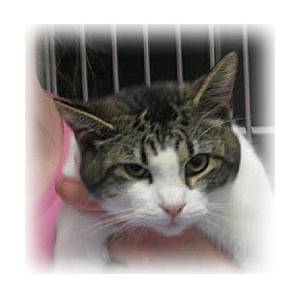

In [7]:
# Set seed
random.seed(42)

# Getting all image paths
image_paths_list = list(Path(image_path).glob("*/*/*.jpg"))

# Get random image path
random_image_path = random.choice(image_paths_list)

# Get image class
image_class = random_image_path.parent.stem

# Open image
img = Image.open(random_image_path)

# Print metadata
print(f"Random image path: {random_image_path}")
print(f'Image class: {image_class}')
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

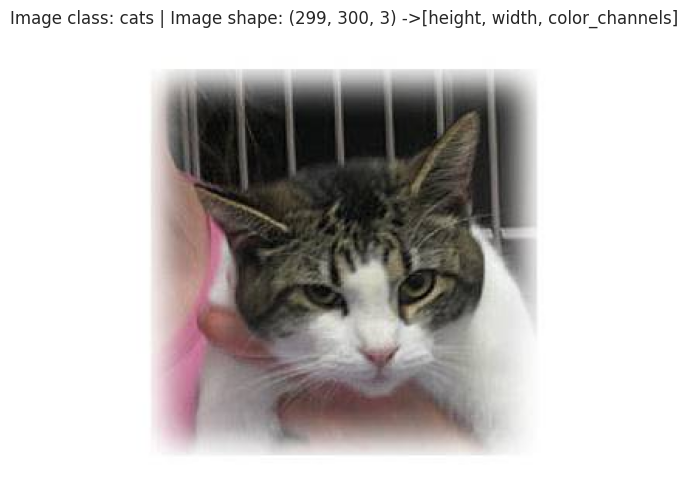

In [8]:
# Turning the image
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} ->[height, width, color_channels]")
plt.axis(False)
plt.show()

# 3. Transforming Data

In [9]:
# Creating transform
IMAGE_SIZE = (224, 224)  # Works for both models

train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),  # Light Augmentation
    transforms.RandomRotation(degrees=10),  # Slight Rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Small Changes
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet Mean/Std
])


test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet Mean/Std
])

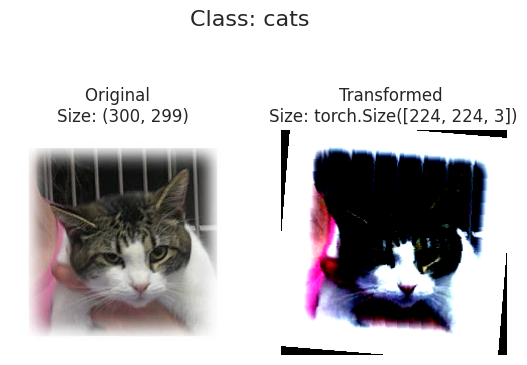

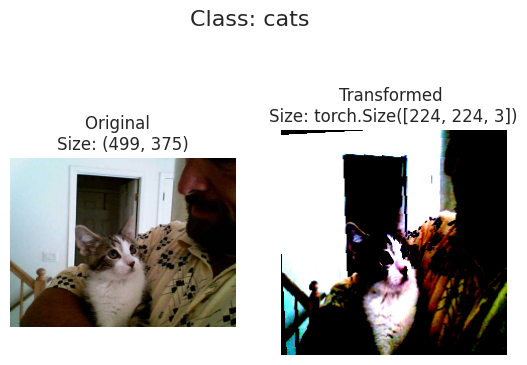

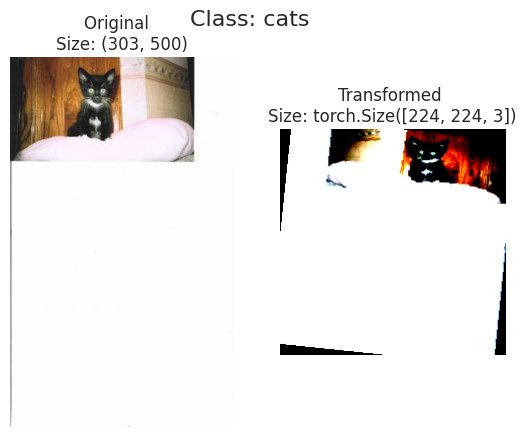

In [10]:
# Create a function to visualize between original image and transformed image

def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)

    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original  \nSize: {f.size}")
            ax[0].axis("off")

            # Transform image
            transformed_image = transform(f).permute(1, 2, 0)

            # Plot the transformed image
            ax[1].imshow(transformed_image)
            ax[1].set_title(f'Transformed \nSize: {transformed_image.shape}')
            ax[1].axis("off")
            fig.suptitle(f"Class: {Path(random_image_path).parent.stem}", fontsize=16)

plot_transformed_images(image_paths_list, transform=train_transform)

# 4. Loading Image Data

In [11]:
# Create training set
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform,
                                  target_transform=None)

# Create testing set
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 20000
    Root location: /root/.cache/kagglehub/datasets/salader/dogs-vs-cats/versions/1/dogs_vs_cats/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=None, hue=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 5000
    Root location: /root/.cache/kagglehub/datasets/salader/dogs-vs-cats/versions/1/dogs_vs_cats/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               

In [12]:
# Get class names as a list
class_names = train_data.classes
print("Class Names:  ", class_names)

# Can also get Class names as a dict
class_dict = train_data.class_to_idx
print("Class Dict:  ", class_dict)

# Check the lengths
print("There are", len(train_data), "training images")
print("There are", len(test_data), "testing images")

Class Names:   ['cats', 'dogs']
Class Dict:   {'cats': 0, 'dogs': 1}
There are 20000 training images
There are 5000 testing images


In [13]:
img, label = train_data[1][0], train_data[1][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[-1.9467, -1.3473, -1.3473,  ..., -1.9467, -1.9467, -1.9467],
         [-1.9467, -1.3644, -1.3644,  ...,  0.8276,  1.1872,  1.1529],
         [-1.9467, -1.3815, -1.3987,  ...,  0.8104,  1.1187,  1.0844],
         ...,
         [-1.5185, -1.6042, -1.6384,  ..., -1.2788, -1.3130, -1.9467],
         [-1.5528, -1.6213, -1.6555,  ..., -1.3644, -1.2103, -1.9467],
         [-1.9467, -1.9467, -1.9467,  ..., -1.3302, -1.1760, -1.9467]],

        [[-1.8606, -1.1779, -1.1779,  ..., -1.8606, -1.8606, -1.8606],
         [-1.8606, -1.1779, -1.1954,  ...,  0.9755,  1.3081,  1.2556],
         [-1.8606, -1.1954, -1.2479,  ...,  0.9405,  1.2031,  1.2031],
         ...,
         [-1.4755, -1.5455, -1.5805,  ..., -1.3704, -1.3880, -1.8606],
         [-1.4930, -1.5630, -1.5980,  ..., -1.4580, -1.2829, -1.8606],
         [-1.8606, -1.8606, -1.8606,  ..., -1.4055, -1.2129, -1.8606]],

        [[-1.6302, -1.0027, -0.9853,  ..., -1.6302, -1.6302, -1.6302],
         [-1.6302, -1.0201, -1.

## 4.1 Loading DataLoaders

In [14]:
# Batch Size
BATCH_SIZE = 32
torch.manual_seed(42)

# How many subprocesses will be used for data loading (higher=more)
NUM_WORKERS = os.cpu_count()

# Turn train and test Datasets into Dataloaders
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ec6b686a990>,
 <torch.utils.data.dataloader.DataLoader at 0x7ec6b6989190>)

# 5. Custom Own Model for Classfication

In [46]:
# Define the custom CNN model
class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layers = nn.Sequential(
            # Conv Layer 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Input: 3 channels, Output: 32 channels
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),  # Output size: (32, 112, 112)

            # Conv Layer 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Input: 32 channels, Output: 64 channels
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),  # Output size: (64, 56, 56)

            # Conv Layer 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Input: 64 channels, Output: 128 channels
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),  # Output size: (128, 28, 28)

            # Conv Layer 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # Input: 128 channels, Output: 256 channels
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),  # Output size: (256, 14, 14)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),  # Flatten the output from conv layers
            nn.Linear(256 * 14 * 14, 512),  # Fully connected layer
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout for regularization
            nn.Linear(512, 2)  # Output layer (2 classes: dog and cat)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x

# Instantiate the model
model = CustomCNN().to(device)

## 5.2 Try a forward pass on a single image

In [47]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model.eval()
with torch.inference_mode():
    pred_logits = model(img_single.to(device))

# 4. Convert logits -> prediction label
pred_probs = torch.softmax(pred_logits, dim=1)  # Convert to probabilities
pred_label = torch.argmax(pred_probs, dim=1)    # Get predicted class index

# 5. Print outputs
print(f"Output logits:\n{pred_logits}\n")
print(f"Predicted probabilities:\n{pred_probs}\n")
print(f"Predicted label:\n{pred_label.item()}\n")
print(f"Actual label:\n{label_single.item()}")

Single image shape: torch.Size([1, 3, 224, 224])

Output logits:
tensor([[0.0352, 0.0046]], device='cuda:0')

Predicted probabilities:
tensor([[0.5077, 0.4923]], device='cuda:0')

Predicted label:
0

Actual label:
0


In [48]:
img, label = next(iter(train_dataloader))

# Note that batch size will now be 1.
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


## 5.3 Model Summary

In [49]:
import importlib.util

if importlib.util.find_spec("torchinfo") is None:
    import subprocess
    subprocess.run(["pip", "install", "torchinfo"])

from torchinfo import summary

# Display model summary
summary(model, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CustomCNN                                [1, 3, 224, 224]          [1, 2]                    --
├─Sequential: 1-1                        [1, 3, 224, 224]          [1, 256, 14, 14]          --
│    └─Conv2d: 2-1                       [1, 3, 224, 224]          [1, 32, 224, 224]         896
│    └─ReLU: 2-2                         [1, 32, 224, 224]         [1, 32, 224, 224]         --
│    └─BatchNorm2d: 2-3                  [1, 32, 224, 224]         [1, 32, 224, 224]         64
│    └─MaxPool2d: 2-4                    [1, 32, 224, 224]         [1, 32, 112, 112]         --
│    └─Conv2d: 2-5                       [1, 32, 112, 112]         [1, 64, 112, 112]         18,496
│    └─ReLU: 2-6                         [1, 64, 112, 112]         [1, 64, 112, 112]         --
│    └─BatchNorm2d: 2-7                  [1, 64, 112, 112]         [1, 64, 112, 112]         128
│    └─MaxPool2d: 2-8        

## 5.4 Training Model Function

In [50]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    # Put model in train mode
    model.train()

    # Setup train loss and accuracy tracking
    train_loss, total_correct, total_samples = 0, 0, 0

    # Loop through data loader data batches
    for images, labels in dataloader:
        # Send data to target device
        images, labels = images.to(device), labels.to(device)

        # 1. Forward pass
        labels_pred = model(images)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(labels_pred, labels)
        train_loss += loss.item() * images.size(0)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Compute accuracy
        labels_pred_class = torch.argmax(labels_pred, dim=1)
        total_correct += (labels_pred_class == labels).sum().item()
        total_samples += labels.size(0)

    # Compute train loss and accuracy
    train_loss = train_loss / len(dataloader.dataset)
    train_acc = total_correct / total_samples
    return train_loss, train_acc

## 5.5 Evaluating Model Function

In [51]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
    # Put model in eval mode
    model.eval()

    # Setup test loss and accuracy values
    test_loss = 0
    correct_preds = 0
    total_samples = 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for images, labels in dataloader:
            # Send data to target device
            images, labels = images.to(device), labels.to(device)

            # 1. Forward pass
            test_pred_logits = model(images)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, labels)
            test_loss += loss.item() * images.size(0)

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            correct_preds += (test_pred_labels == labels).sum().item()
            total_samples += labels.size(0)

    #  Compute Test loss and accuracy
    test_loss /= len(dataloader)
    test_acc = correct_preds / total_samples

    return test_loss, test_acc

In [52]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 20,
          device: torch.device = device):

    # Move model to the correct device
    model.to(device)

    # 2. Create empty results dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }


    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs), desc="Training Progress"):
        # Train
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)

        # Test
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print progress
        tqdm.write(f"Epoch {epoch+1}/{epochs} | "
                   f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
                   f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")


        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

## 5.6 Main Function to Train and test model

In [53]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 20

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3, weight_decay=1e-5)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_results = train(model=model,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS,
                      device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 1.1135, Train Acc: 0.6360 | Test Loss: 20.0987, Test Acc: 0.6874
Epoch 2/20 | Train Loss: 0.5964, Train Acc: 0.6836 | Test Loss: 17.0785, Test Acc: 0.7420
Epoch 3/20 | Train Loss: 0.5795, Train Acc: 0.6933 | Test Loss: 16.2164, Test Acc: 0.7092
Epoch 4/20 | Train Loss: 0.5346, Train Acc: 0.7325 | Test Loss: 14.7424, Test Acc: 0.7808
Epoch 5/20 | Train Loss: 0.4730, Train Acc: 0.7772 | Test Loss: 11.1514, Test Acc: 0.8394
Epoch 6/20 | Train Loss: 0.4025, Train Acc: 0.8203 | Test Loss: 9.1714, Test Acc: 0.8754
Epoch 7/20 | Train Loss: 0.3369, Train Acc: 0.8527 | Test Loss: 14.8625, Test Acc: 0.8134
Epoch 8/20 | Train Loss: 0.2991, Train Acc: 0.8767 | Test Loss: 7.2000, Test Acc: 0.9084
Epoch 9/20 | Train Loss: 0.2617, Train Acc: 0.8921 | Test Loss: 7.1258, Test Acc: 0.9130
Epoch 10/20 | Train Loss: 0.2460, Train Acc: 0.9009 | Test Loss: 6.7834, Test Acc: 0.9144
Epoch 11/20 | Train Loss: 0.2308, Train Acc: 0.9075 | Test Loss: 6.3623, Test Acc: 0.9214
Epoch 12/20 |

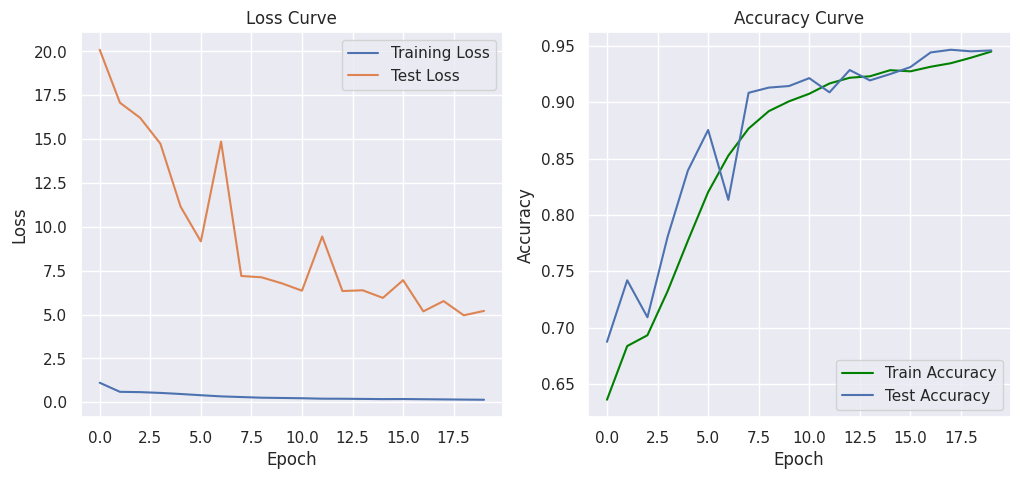

In [59]:
def PlotLossAccuracyCurve(train_loss,train_acc, test_loss, test_acc):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(test_loss, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Accuracy', color='green')
    plt.plot(test_acc, label='Test Accuracy', )
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.show()

PlotLossAccuracyCurve(model_results["train_loss"], model_results["train_acc"], model_results["test_loss"], model_results["test_acc"] )

# 6. Loading Pretrained Model - Resnet18

In [34]:
import torchvision.models as models

# Load pre-trained ResNet18
model_1 = models.resnet18(pretrained=True)

# Modify the final layer for binary classification
model_1.fc = nn.Linear(model_1.fc.in_features, 1)

# move to GPU if available
model_1.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 188MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [35]:
# Display model_1 summary
summary(model_1, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
ResNet                                   [1, 3, 224, 224]          [1, 1]                    --
├─Conv2d: 1-1                            [1, 3, 224, 224]          [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 112, 112]         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3     

In [36]:
import torch.optim as optim

# Define loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.001)

## 6.1 Train and test the pretrained Model(Resnet18)

In [37]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

train_losses = []
test_losses = []
test_accuracies = []

start_time = timer()

num_epochs = 10
for epoch in tqdm(range(num_epochs), desc="Training Progress"):
    model_1.train()
    running_loss = 0.0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.float().to(device)

        # 1. Forward pass
        labels_pred = model_1(images).squeeze()


        # 2. Calculate and accumulate loss
        loss = loss_fn(labels_pred, labels)
        running_loss += loss.item() * images.size(0)

       # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()


    # Print the average loss for the epoch
    epoch_loss = running_loss / len(train_dataloader.dataset)
    train_losses.append(epoch_loss)

    # Evaluation
    model_1.eval()
    test_loss, correct, total = 0.0, 0, 0

    with torch.inference_mode():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.float().to(device)

            # 1. Forward pass
            labels_pred = model_1(images).squeeze()

            # 2. Calculate and accumulate loss
            loss = loss_fn(labels_pred, labels)
            test_loss += loss.item() * images.size(0)

            # 3. Calculate accuracy
            predicted = (labels_pred > 0).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Calculate average test loss and accuracy for the epoch
    test_loss /= len(test_dataloader.dataset)
    test_accuracy = 100 * correct / total

    tqdm.write(f"Epoch {epoch+1}/{num_epochs} | "
               f"Train Loss: {epoch_loss:.4f} | "
               f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

end_time = timer()
print(f'Total training time: {end_time-start_time:.3f} seconds')

Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 | Train Loss: 0.1814 | Test Loss: 0.1300, Test Accuracy: 94.68%
Epoch 2/10 | Train Loss: 0.1321 | Test Loss: 0.0940, Test Accuracy: 95.90%
Epoch 3/10 | Train Loss: 0.1092 | Test Loss: 0.1228, Test Accuracy: 94.98%
Epoch 4/10 | Train Loss: 0.1059 | Test Loss: 0.1198, Test Accuracy: 95.42%
Epoch 5/10 | Train Loss: 0.0944 | Test Loss: 0.1191, Test Accuracy: 95.30%
Epoch 6/10 | Train Loss: 0.0887 | Test Loss: 0.0888, Test Accuracy: 96.36%
Epoch 7/10 | Train Loss: 0.0810 | Test Loss: 0.0682, Test Accuracy: 97.34%
Epoch 8/10 | Train Loss: 0.0767 | Test Loss: 0.1174, Test Accuracy: 95.38%
Epoch 9/10 | Train Loss: 0.0700 | Test Loss: 0.0842, Test Accuracy: 96.64%
Epoch 10/10 | Train Loss: 0.0640 | Test Loss: 0.1027, Test Accuracy: 96.14%
Total training time: 1225.869 seconds


## 6.3 Plot the loss and Accuracy Curve

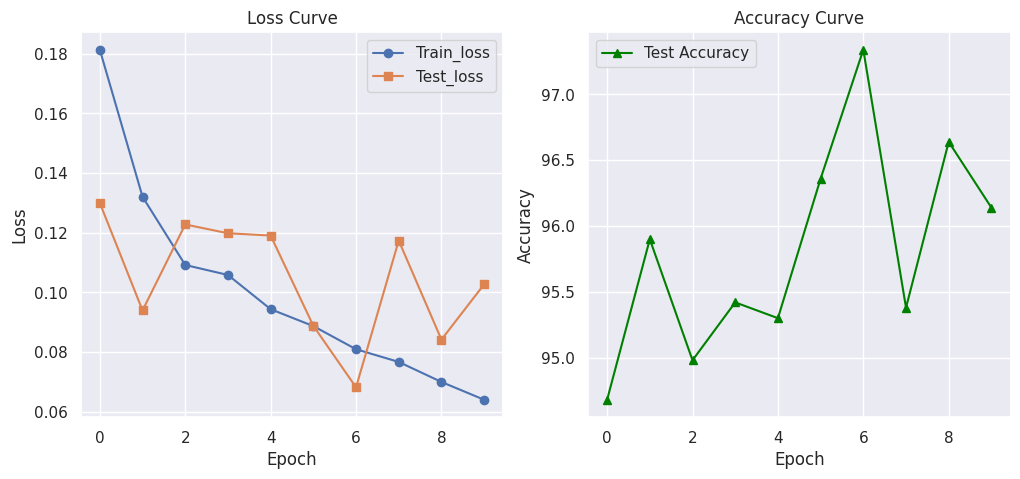

In [38]:
# Plot the loss and accuracy curves
plt.figure(figsize=(12, 5))

# Plot training and test loss
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train_loss', marker='o')
plt.plot(test_losses, label="Test_loss", marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label="Test Accuracy", color='green', marker='^')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

# 7. Prediction with Best Accuracy Model

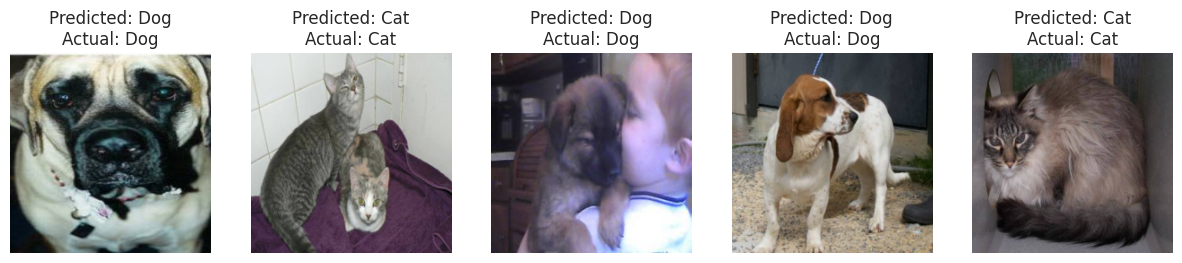

In [40]:
import torchvision.transforms as transforms


def visualize_predictions(model, test_dataloader, device, num_images=5):
    model.eval()

    indices = random.sample(range(len(test_data)), num_images)
    images = [test_data[i][0] for i in indices]  # Get images
    labels = [test_data[i][1] for i in indices]  # Get labels

    images = torch.stack(images).to(device)
    labels = torch.tensor(labels).to(device)

    # Make predictions
    with torch.inference_mode():
        outputs = model(images).squeeze()
        predicted = (outputs > 0).float()

    # Convert images back to CPU and denormalize for visualization
    images = images.cpu()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    denormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

    # Plot the images with predictions
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)     # Clip values to [0, 1] for valid image display

        axes[i].imshow(img)
        axes[i].set_title(f'Predicted: {"Dog" if predicted[i] == 1 else "Cat"}\nActual: {"Dog" if labels[i] == 1 else "Cat"}')
        axes[i].axis('off')

    plt.show()

# Call the prediction function
visualize_predictions(model_1, test_dataloader=test_dataloader, device=device)